# Preparation of the XML for FSLview/Mango atlas

_Leonardo dec 2019_

To be run locally with py3bis kernel. Instructions [here](https://research.google.com/colaboratory/local-runtimes.html)

__NB__: make sure you `pip install jupyter_http_over_ws==0.0.7`

In order to use an atlas in FSLview, an XML must be generated,containing 4 values: the ID of the ROI - starting from 0 - and the medoid of the ROI, that is the voxel in the ROI which minimizes the distance across all other voxels in the ROI.

For FSL, coordinates should be provided in the volume space, not in MNI

Once created, the Atlas XML and the folder with the NIFTI image should be placed in `$FSLDIR/data/atlases`

## Import libraries and define the Atlas nifti

In [57]:
import numpy as np
import nibabel as nib
from scipy.spatial.distance import pdist, squareform
import numpy as np
import pandas as pd
import sys


hemi = 'RH'
atlas_root = 'Schaefer100_ribbon_subcort_' + hemi

bd = '/Users/luser/GoogleDrive/data/atlases/Schaefer100_ribbon_subcort_tracto'
FSL_atlas_dir = bd + '/FSL_version'

resolution = '2mm'
FSL_atlas_image_path = '/' + atlas_root + '/' + atlas_root + '-' + resolution

atlas = nib.load(bd + '/' + atlas_root + '.nii.gz')

Yeo_flavour = '17'
atlas_csv = bd + '/Schaefer100_ribbon_subcort_labels_Yeo' + Yeo_flavour + '_' + hemi + '.csv'
atlas_info = pd.read_csv(atlas_csv)

print(FSL_atlas_image_path)



/Schaefer100_ribbon_subcort_RH/Schaefer100_ribbon_subcort_RH-2mm


## Calculate medoids for each ROI in the atlas

In [58]:
def calculate_medoid(atlas, ROI_numba, space='volume'):
    """
    Usage: calculate_medoid(atlas, ROI_numba, space='volume')

    atlas : a NIFTI image imported with nibabel
    ROI_numba : 1..N ROI ID/label/value in the atlas
    space : 'volume' or 'MNI'
    
    Leonardo dec 2019
    """
    ROI_coords = np.where(atlas.get_data() == ROI_numba)
    ROI_ijks = np.array([ROI_coords[0], ROI_coords[1], ROI_coords[2]]).T

    D = squareform(pdist(ROI_ijks))
    Dsum = np.sum(D, axis=0)
    
    ijk_min = np.argmin(Dsum)
    ijk_medoid = ROI_ijks[ijk_min,:] # volume space
    MNI_coord_medoid = nib.affines.apply_affine(atlas.affine, ijk_medoid) # MNI space
    
    if space == 'MNI':
        medoid = np.concatenate(([ROI_numba], MNI_coord_medoid), axis=0)
    else:
        medoid = np.concatenate(([ROI_numba], ijk_medoid), axis=0)

    return medoid


NROIs = len(np.unique(atlas.get_data())) - 1 # ROI numba start at 1
medoids = np.zeros((NROIs, 4), dtype='int')

for i in np.arange(NROIs):
    ROI_numba = i + 1
    medoids[i,:] = calculate_medoid(atlas, ROI_numba, space='volume')
    
medoids[0:5,]



<ipython-input-58-b05352986249>:29: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  NROIs = len(np.unique(atlas.get_data())) - 1 # ROI numba start at 1
<ipython-input-58-b05352986249>:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ROI_coords = np.where(atlas.get_data() == ROI_numba)


array([[ 1, 31, 30, 31],
       [ 2, 35, 18, 33],
       [ 3, 27, 22, 44],
       [ 4, 41, 25, 39],
       [ 5, 36, 34, 38]])

## Prepare 4D version of the atlas

In [59]:
%%bash -s $hemi  $FSL_atlas_dir  $FSL_atlas_image_path 

hemi=${1}
basedir=${2}/Schaefer100_ribbon_subcort_${hemi}
nii=${basedir}/Schaefer100_ribbon_subcort_${hemi}-2mm

echo $basedir 
# fslinfo $nii

nROIs=`fslstats $nii -R | awk '{print $2}' | awk -F. '{print $1}'`
echo $nROIs

for ((i=0;i<=nROIs;i++)); do
  
  ipad=`printf "%04d\n" $i`
  # echo ${ipad}
  
  fslmaths ${nii} -thr ${i} -uthr ${i} $basedir/roi_${ipad}
  # fslstats $basedir/roi_${ipad} -V
  
done

fslmerge -t ${nii}_4D `ls $basedir/roi*`
rm $basedir/roi*


/Users/luser/GoogleDrive/data/atlases/Schaefer100_ribbon_subcort_tracto/FSL_version/Schaefer100_ribbon_subcort_RH
66


## Prepare XML for FSL

A small tut on how to write XML in Python is [here](https://pymotw.com/2/xml/etree/ElementTree/create.html)

In [0]:
from xml.etree.ElementTree import Element, SubElement, Comment, tostring
from xml.etree import ElementTree
from xml.dom import minidom


atlas_labels = atlas_info['original_label'].values


def prettify(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ElementTree.tostring(elem)
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

ROOT = Element('atlas')

header = SubElement(ROOT, 'header')

name = SubElement(header, 'name')
name.text = atlas_root

shortname = SubElement(header, 'shortname')
shortname.text = 'S100_subcort_' + hemi

tipo = SubElement(header, 'type')
tipo.text = 'Probabilistic'

images = SubElement(header, 'images')

imagefile = SubElement(images, 'imagefile')
imagefile.text = FSL_atlas_image_path + '_4D' 

summaryimagefile = SubElement(images, 'summaryimagefile')
summaryimagefile.text = FSL_atlas_image_path 


data = SubElement(ROOT, 'data')

# place a first line pointing to nothing
# this is how the FSL Label atlases work
label = SubElement(data, 'label')
label.text = '*.*.*.*.*'
label.set('index', '0')
label.set('x', '0')
label.set('y', '0')
label.set('z', '0')


for i in np.arange(len(atlas_labels)):
  long_label = atlas_labels[i]
  ROI_FSLnumba = str(medoids[i,0])
  x = str(medoids[i,1])
  y = str(medoids[i,2])
  z = str(medoids[i,3])

  label = SubElement(data, 'label')
  label.text = long_label
  label.set('index', ROI_FSLnumba)
  label.set('x', x)
  label.set('y', y)
  label.set('z', z)


# print(prettify(ROOT))

# tree = ElementTree.ElementTree(ROOT)

xmlstr = minidom.parseString(ElementTree.tostring(ROOT)).toprettyxml(indent="   ")
with open(FSL_atlas_dir + '/' + atlas_root + '.xml', "wb") as f:
    f.write(xmlstr.encode('ISO-8859-1'))



## Prepare files for [Neuromarvl](https://immersive.erc.monash.edu/neuromarvl/)

- coordinates : `NROI-by-[x y z]` matrix of medoids
- labels : list of NROI labels, one for each line
- attributes : whatever attribute per node: `NROI-by-A` where A is the number of attributes 
- matrix : the properties of the network, of size NROI-by-NROI

In all files, the delimiter is space/tab

/Users/luser/anaconda/envs/py3/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


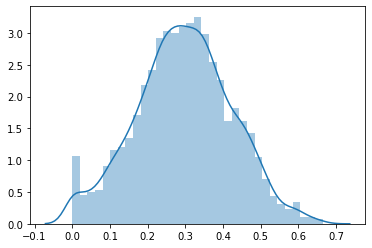

0.0

In [0]:
Neuromarvl_dir = bd + '/Neuromarvl_files'

# The same function created above can be used to get the medoids in MNI coordinates
NROIs = len(np.unique(atlas.get_data())) - 1 # ROI numba start at 1
medoids_MNI = np.zeros((NROIs, 4), dtype='int')

for i in np.arange(NROIs):
    ROI_numba = i + 1
    medoids_MNI[i,:] = calculate_medoid(atlas, ROI_numba, space='MNI')
    
medoids_MNI_coords = medoids_MNI[:,1:4]


# coordinates in MNI [TO COMPLETE WITH HEADER!]
np.savetxt(
    Neuromarvl_dir + '/' + atlas_root + '_coordinates.txt',
    medoids_MNI_coords,
    fmt='%i'
)


# labels
labels = atlas_info['original_label'].values
np.savetxt(
    Neuromarvl_dir + '/' + atlas_root + '_labels.txt',
    labels,
    fmt='%s'
)


# attributes [TO COMPLETE WITH HEADER!]
# Remember to add 1 since Python starts from 0
# otherwise Neuromarvl will not display a damn!
atlas_info['modules'] = pd.Categorical(atlas_info['main_label'])
module_ID = atlas_info['modules'].cat.codes.values + 1
np.savetxt(
    Neuromarvl_dir + '/' + atlas_root + '_attributes.txt',
    module_ID,
    fmt='%i'
)


# matrix [TO COMPLETE!!!]
# very important: the values MUST be separated only by one space, not tab,
# otherwise Neuromarvl will not display the edges. 
# That's why the format is %5.3f
import matplotlib.pyplot as plt
import seaborn as sns

mat = np.corrcoef(np.random.randn(NROIs, NROIs)) + 0.3
mat[mat>1] = 1
np.fill_diagonal(mat, 0)
mat = np.abs(mat)

sns.distplot(mat.flatten())
plt.show()

np.savetxt(
    Neuromarvl_dir + '/' + atlas_root + '_matrix.txt',
    mat,
    fmt='%5.3f',
    delimiter = ' ',
    newline='\r\n'
)

np.min(mat)
